CNN ResNet50

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

Constantes Globales

In [2]:
NUM_CLASSES = 2
CHANNELS = 3
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'binary_crossentropy'
LOSS_METRICS = ['accuracy']
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10
BATCH_SIZE = 32
BATCH_SIZE_VALIDATION = 32
BATCH_SIZE_TESTING = 1

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from glob import glob

Carga el Modelo de ResNet50 con los datso preentrenados para imagenet

In [5]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[0].trainable = False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Definine descenso de gradiente estocástico como optimizador del modelo para entrenar y compila

In [7]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

C:\ProgramData\Anaconda3\envs\gpu_ok\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Preparamos los datos de test, entrenamiento y validacion

In [8]:
train_path = 'dividido/train'
valid_path = 'dividido/val'
test_path = 'dividido/test'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
test_image_files = glob(valid_path + '/*/*.jp*g')

In [9]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_directory(
        'dividido/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
        'dividido/val',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
test_generator = data_generator.flow_from_directory(
        'dividido/test',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 3023 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 379 images belonging to 2 classes.


In [10]:
(BATCH_SIZE, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(32, 95, 32, 12)

### Se entrena el modelo con MonkeyPox Data Set

In [16]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best_resnet.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [19]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=len(image_files) // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(valid_image_files) // BATCH_SIZE,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
66/66 [==============================] - 134s 1s/step - loss: 0.4163 - accuracy: 0.8215 - val_loss: 0.2929 - val_accuracy: 0.8906


C:\ProgramData\Anaconda3\envs\gpu_ok\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
66/66 [==============================] - 107s 2s/step - loss: 0.2469 - accuracy: 0.9021 - val_loss: 0.2668 - val_accuracy: 0.8906
Epoch 3/10
66/66 [==============================] - 95s 1s/step - loss: 0.2069 - accuracy: 0.9251 - val_loss: 0.2168 - val_accuracy: 0.9180
Epoch 4/10
66/66 [==============================] - 95s 1s/step - loss: 0.1571 - accuracy: 0.9456 - val_loss: 0.2313 - val_accuracy: 0.9180
Epoch 5/10
66/66 [==============================] - 95s 1s/step - loss: 0.1573 - accuracy: 0.9446 - val_loss: 0.1820 - val_accuracy: 0.9453
Epoch 6/10
66/66 [==============================] - 95s 1s/step - loss: 0.1402 - accuracy: 0.9508 - val_loss: 0.1965 - val_accuracy: 0.9492
Epoch 7/10
66/66 [==============================] - 95s 1s/step - loss: 0.1139 - accuracy: 0.9618 - val_loss: 0.1664 - val_accuracy: 0.9414
Epoch 8/10
66/66 [==============================] - 94s 1s/step - loss: 0.1230 - accuracy: 0.9537 - val_loss: 0.1384 - val_accuracy: 0.9648
Epoch 9/10
66/66 [=

In [15]:
import tensorflow
model = tensorflow.keras.models.load_model('resnet_ok.h5')

### Metricas

In [20]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


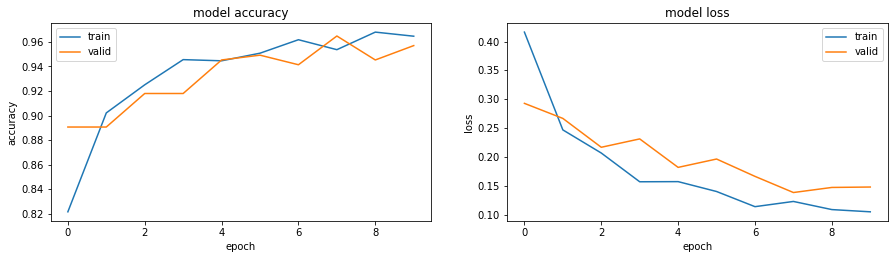

In [21]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [16]:
test_generator = data_generator.flow_from_directory(
    directory = 'dividido/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 379 images belonging to 2 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n'

Predicciones

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
test_generator = data_generator.flow_from_directory(
        'dividido/test',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

labels = [None] * len(test_generator.class_indices)
for k, v in test_generator.class_indices.items():
    labels[v] = k

Found 379 images belonging to 2 classes.


In [19]:
model.evaluate(test_generator)

12/12 [==============================] - 63s 3s/step - loss: 0.1765 - accuracy: 0.9314


[0.17645655572414398, 0.9313983917236328]

In [34]:
import tensorflow
y_pred = tensorflow.math.round(model.predict(test_generator))
y_true = []


In [45]:
model.save('resnet_ok.h5')

C:\ProgramData\Anaconda3\envs\gpu_ok\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [20]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE=[IMAGE_RESIZE,IMAGE_RESIZE]
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in data_generator.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=BATCH_SIZE * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    acsc=accuracy_score(targets, predictions)
    return cm, acsc,predictions,targets


#cm,ascs,z,zz = get_confusion_matrix(train_path, len(image_files))
#print(cm,ascs)
#valid_cm,valid_ascs,z,zz = get_confusion_matrix(valid_path, len(valid_image_files))
#print(valid_cm,valid_ascs)
test_cm, test_ascs,y_pred,y_true = get_confusion_matrix(test_path, len(test_image_files))
print(test_cm,test_ascs)
print(classification_report(y_true, y_pred, target_names=labels))

Generating confusion matrix 260
Found 379 images belonging to 2 classes.
[[141   8]
 [ 15 156]] 0.928125
              precision    recall  f1-score   support

           M       0.90      0.95      0.92       149
           N       0.95      0.91      0.93       171

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.93       320
weighted avg       0.93      0.93      0.93       320



Mostrar la matriz de confusion

Confusion matrix, without normalization
[[141   8]
 [ 15 156]]


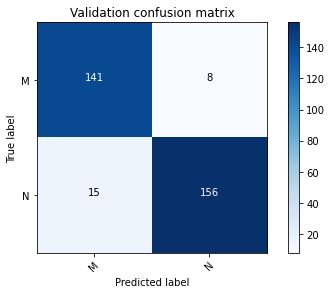

In [22]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#plot_confusion_matrix(cm, labels, title='Train confusion matrix')
#plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')
plot_confusion_matrix(test_cm, labels, title='Validation confusion matrix')